In [1]:
from lipunova import Shakura_Sunyaev_Disk, Advective_Disk_With_Outflows, Advective_Disk_Without_Outflows
from lipunova import isco_radius, eddington_accretion_rate, keplerian_angular_w, find_rsph
import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.constants import M_sun

In [2]:
outdir = "lipunova/%s" % "testing_disks"

if not os.path.isdir(outdir):
    os.mkdir(outdir)
alpha = 0.1
M = 10 * M_sun.to(u.g).value
R0 = isco_radius(M, 0)

## Shakura & Sunyaev disk (Conservative and non-advective disk)

Disk Shakura_Sunyaev_Disk with M = 10.0 M_sun, dot(m) = 0.5 and alpha = 0.1 and spin = 0.0
Is energy conserved in Shakura_Sunyaev_Disk disks?
True
According to SS73 the maximum of Qr^2 occurs at 2.25R_0:
True


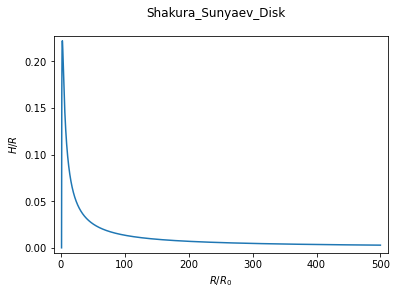

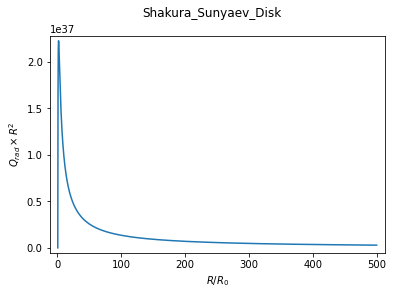

In [3]:
mdot = 0.5
Mdot_0 = eddington_accretion_rate(M  / (M_sun.to(u.g).value), R0) * mdot        
disk = Shakura_Sunyaev_Disk(M, mdot, alpha, Rmin=1, Rmax=500, spin=0)
R = np.arange(disk.Rmin, disk.Rmax, 0.05) * disk.R0
w = keplerian_angular_w(R, disk.M)
height = disk.H(R, w)
Qrad = disk.Q_rad(height, R)
Wrphi = disk.torque(R, w)
r = R / disk.R0
fig = plt.figure()
fig.suptitle("%s" % disk.name)
plt.plot(r, height/ R)
plt.margins(x=0.025, y=0.025)
plt.ylabel("$H/R$")
plt.xlabel("$R / R_0$")
fig = plt.figure()
fig.suptitle("%s" % disk.name)
plt.plot(r, Qrad * R**2)
plt.margins(x=0.025, y=0.025)
plt.ylabel("$Q_{rad} \\times R^2$")
plt.xlabel("$R / R_0$")
Q = -3/4 * w * Wrphi
print("Is energy conserved in %s disks?" % disk.name)
print(np.allclose(Qrad, Q))
max_Qr2 = np.argmax(Qrad * R**2)
print("According to SS73 the maximum of Qr^2 occurs at 2.25R_0:")
print(np.allclose(R[max_Qr2] / disk.R0, 2.25))

## Advective Disk Without Outflows (Conservative)

Disk no_outflows with M = 10.0 M_sun, dot(m) = 100.0 and alpha = 0.1 and spin = 0.0
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          2.65e+00       0.00e+00         4990             3       
       2          3.10e+00       7.44e-23         4993             3       
       3          3.32e+00       2.32e-23         4996             5       
       4          3.41e+00       1.84e-22         5001             5       
       5          3.45e+00       1.65e-23         5006             5       
       6          3.46e+00       1.04e-22         5011             5       
       7          3.46e+00       2.98e-23         5016             5       
       8          3.46e+00       1.14e-22         5021             5       
       9          3.46e+00       1.09e-22         5026             5       
      10          3.46e+00       1.09e-22         5031             5       
      11          3.46e+00       2.15e-23         5036             5       
    

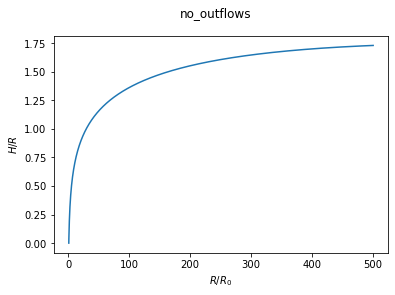

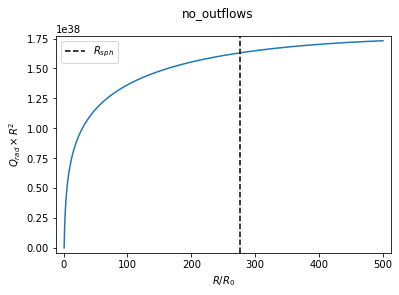

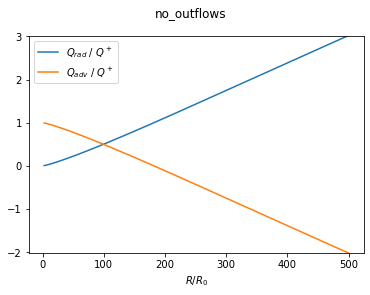

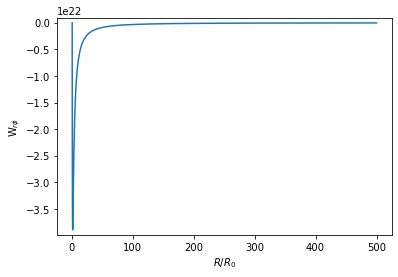

In [4]:
mdot = 100
Mdot_0 = eddington_accretion_rate(M  / (M_sun.to(u.g).value), R0) * mdot        
disk = Advective_Disk_Without_Outflows(M, mdot, alpha, Rmin=1, Rmax=500)
solution = disk.solve(max_nodes=500000, step=0.1)
R = solution.x
w = keplerian_angular_w(R, disk.M)
height = solution.y[0]
fig = plt.figure()
fig.suptitle("%s" % disk.name)
r = R / disk.R0
plt.plot(r, height/ R)
plt.ylabel("$H/R$")
plt.xlabel("$R / R_0$")

Qrad = disk.Q_rad(height, R)
fig = plt.figure()
fig.suptitle("%s" % disk.name)
plt.plot(r, Qrad * R**2)
plt.ylabel("$Q_{rad} \\times R^2$")
Rsph, L = find_rsph(Qrad, R, disk.M)
plt.margins(x=0.025, y=0.025)
plt.axvline(Rsph / disk.R0, color="black", label="$R_{sph}$", ls="--")
plt.legend()
plt.xlabel("$R / R_0$")

Wrphi = disk.torque(R, w)
dWrphi = disk.torque_derivative(R, w)
rho = disk.density(Wrphi, height, w)
Mdot = disk.Mdot_0
dH = disk.Hprime(Mdot, height, R, Wrphi, dWrphi)
drho = disk.densityPrime(Wrphi, dWrphi, height, dH, Mdot, R)
Qadv = disk.Q_adv(Mdot, height, dH, rho, drho, R)
Q = -3/4 * w * Wrphi

fig = plt.figure()
fig.suptitle("%s" % disk.name)
margin = 200
print("Note that the zero-torque boundary condition creates a singularity at R_0 (Abramowicz+1988)")
plt.plot(r[margin:], (Qrad / Q)[margin:], label="$Q_{rad}$ / $Q^+$")
plt.plot(r[margin:], (Qadv / Q)[margin:], label="$Q_{adv}$ / $Q^+$")
plt.xlabel("$R / R_0$")
plt.legend()
plt.margins(y=0.0)
plt.legend()

plt.figure()
fig.suptitle("%s" % disk.name)
plt.plot(r, Wrphi)
plt.xlabel("$R / R_0$")
plt.ylabel("W$_{r\phi}$")
plt.margins(y=0.025)

We can see that advection transports the energy inwards in the inner regions, while transports the generated radiation outwards beyond R ~ 100R_0. Thus the radii beyond 100R_0 radiate energy from the inner regions, thereby exceeding the energy generated in these radii.

## Advective disk with outflows (non-conservative)

In [10]:
disk = Advective_Disk_With_Outflows(M, mdot, alpha, Rmin=1, spin=0)
disk.Rmax = disk.Rsph # set the maximum radius to the spherization radius where the outflow starts to develop
solution = disk.solve(step=1, max_nodes=800000) # reduce the step to reduce the computational burden
R = solution.x
height = solution.y[0]
Mdot = solution.y[1]
Wrphi = solution.y[2]
w = keplerian_angular_w(R, disk.M)

Disk with_outflows with M = 10.0 M_sun, dot(m) = 100.0 and alpha = 0.1 and spin = 0.0
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.34e+01       7.42e-10          102            132      
       2          2.63e+02       9.69e-02          234            247      
       3          7.11e+01       1.97e+06          481            56       
       4          1.58e+02       6.23e-09          537            128      
       5          1.90e+02       5.71e-01          665            277      
       6          5.09e+03       6.67e+07          942            450      
       7          3.26e+02       1.44e+09         1392            433      
       8          1.14e+03       2.48e-02         1825           2047      
       9          3.43e+04       1.79e-02         3872           6304      
      10          6.69e+04       6.29e-02         10176          16970     
      11          4.03e+03       7.53e-05         27146          50378     
  

True


Text(0.5, 0, '$R / R_0$')

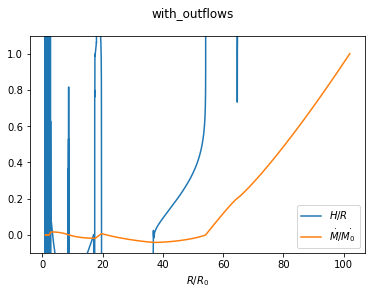

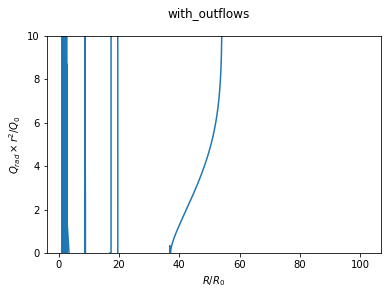

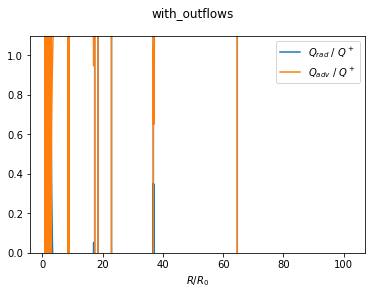

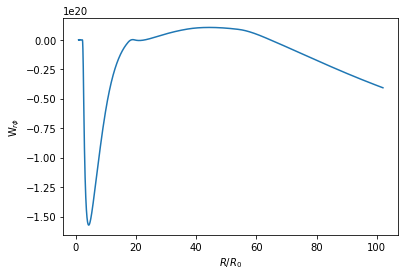

In [11]:
fig = plt.figure()
fig.suptitle("%s" % disk.name)
r = R / disk.R0
plt.plot(r, height/ R, label="$H/R$")
plt.plot(r, Mdot / disk.Mdot_0, label="$\dot{M} / \dot{M_0}$")
plt.xlabel("$R / R_0$")
plt.ylim(bottom=-0.1, top=1.1)
plt.legend()

Qrad = disk.Q_rad(height, R)
#Qrad[-1] = 0 # boundary condition
fig = plt.figure()
fig.suptitle("%s" % disk.name)
Q0 = keplerian_angular_w(disk.R0, disk.M) * disk.Mdot_0 / (8 * np.pi) # just a normalization factor
plt.plot(r, Qrad * r**2 / Q0, label="$Q_{rad} r^2 / Q_0$")
plt.ylim(bottom=0, top=10)
plt.xlabel("$R / R_0$")
plt.ylabel("$Q_{rad} \\times r^2 / Q_0$")


rho = disk.density(Wrphi, height, w)
dWrphi = disk.torque_derivative(Mdot, Wrphi, R, w)
dH = disk.Hprime(Mdot, height, R, Wrphi, dWrphi)
dH_simple = disk.Hprime_simplified(Mdot, height, R, Wrphi, dWrphi)
print(np.allclose(dH, dH_simple))
drho = disk.densityPrime(Wrphi, dWrphi, height, dH, Mdot, R)
Qadv = disk.Q_adv(Mdot, height, dH, rho, drho, R)
Q = -3/4 * w * Wrphi
fig = plt.figure()
fig.suptitle("%s" % disk.name)
margin = 200
plt.plot(r[margin:], (Qrad / Q)[margin:], label="$Q_{rad}$ / $Q^+$")
plt.plot(r[margin:], (Qadv / Q)[margin:], label="$Q_{adv}$ / $Q^+$")
plt.ylim(bottom=0, top=1.1)
plt.legend()
plt.xlabel("$R / R_0$")

plt.figure()
fig.suptitle("%s" % disk.name)
plt.plot(r, Wrphi)
plt.ylabel("W$_{r\phi}$")
plt.xlabel("$R / R_0$")